LiDAR basics
===========
  + Bird's Eye view/ top-view of a point cloud
  + Filtering points from point cloud
  + Examples

In this notebook, we will see how to take bird's eye view(top-view) from a LiDAR point cloud. Then we will see how to filter points from point cloud.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2

## Bird's eye view of a point cloud

In [2]:
def get_bev(points, resolution=0.1, pixel_values=None, generate_img=None):
    '''
    Returns bird's eye view of a LiDAR point cloud for a given resolution.
    Optional pixel_values can be used for giving color coded info the point cloud.
    Optional generate_img function can be used for creating images.
    '''
    
    x = points[:, 0]
    y = points[:, 1]
    z = points[:, 2]
    
    x_range = -1 * np.ceil(y.max()).astype(np.int), ((y.min()/np.abs(y.min())) * np.floor(y.min())).astype(np.int)
    y_range = np.floor(x.min()).astype(np.int), np.ceil(x.max()).astype(np.int)

    # Create mapping from a 3D point to a pixel based on resolution
    # floor() used to prevent issues with -ve vals rounding upwards causing index out bound error
    x_img = (-y / resolution).astype(np.int32) - int(np.floor(x_range[0]/resolution))
    y_img = (x / resolution).astype(np.int32) - int(np.floor(y_range[0]/resolution))

    img_width  = int((x_range[1] - x_range[0])/resolution)
    img_height = int((y_range[1] - y_range[0])/resolution)

    if pixel_values is None:
        pixel_values = (((z - z.min()) / float(z.max() - z.min())) * 255).astype(np.uint8)

    if generate_img is None:
        img = np.zeros([img_height, img_width], dtype=np.uint8)
        img[-y_img, x_img] = pixel_values
        return img
    
    return generate_img(img_height, img_width, -y_img, x_img, pixel_values)

### Examples of `get_bev()`

In [3]:
points = np.fromfile('sample_data/umm_000015.bin', dtype=np.float32).reshape(-1, 4)

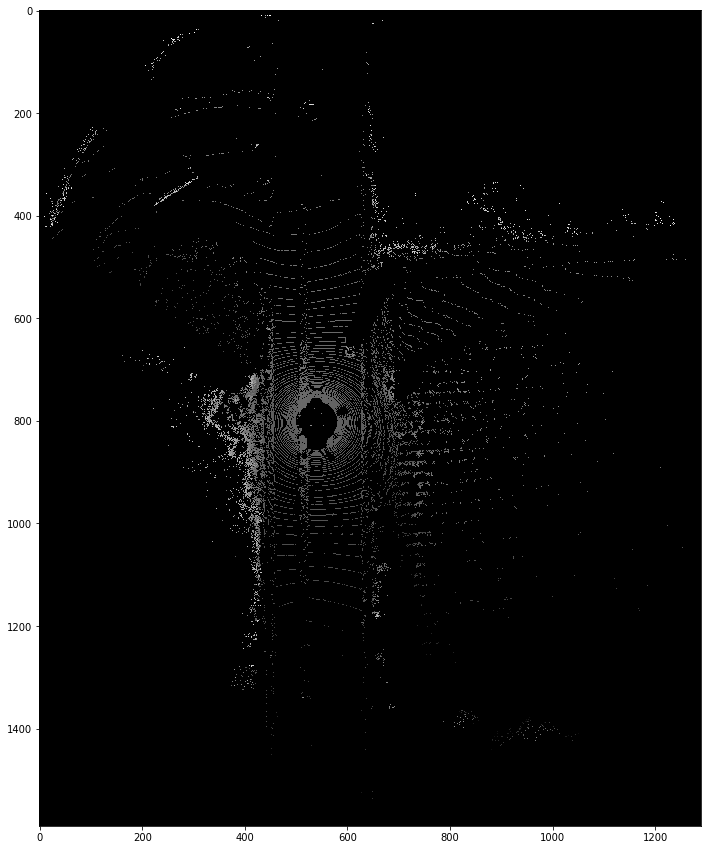

In [4]:
im = get_bev(points)
f, axes = plt.subplots(1, 1, figsize=(15, 15))
plt.imshow(im, cmap='gray')

### Generation of top view heatmap

In [5]:
def get_distance_pixels(points, min_distance=0, max_distance=70):
    '''
    Returns distance encoded pixel values
    '''
    distance = np.sqrt(points[:, 0] ** 2 + points[:, 1] ** 2 + points[:, 2] ** 2)
    np.clip(distance, 0, max_distance, out=distance) 
    return (((distance - min_distance) / (max_distance - min_distance)) * 120).astype(np.uint8)

def get_heatmap(height, width, y_img, x_img, pixel_values):
    '''
    Returns heatmap as RGB image. Near values are red; Far is blue.
    '''
    hsv_ = cv2.cvtColor(np.zeros([height, width, 3], dtype=np.uint8), cv2.COLOR_RGB2HSV)
    
    hsv_[y_img, x_img, 0] = pixel_values
    hsv_[y_img, x_img, 1] = 255
    hsv_[y_img, x_img, 2] = 255
    
    return cv2.cvtColor(hsv_, cv2.COLOR_HSV2RGB)

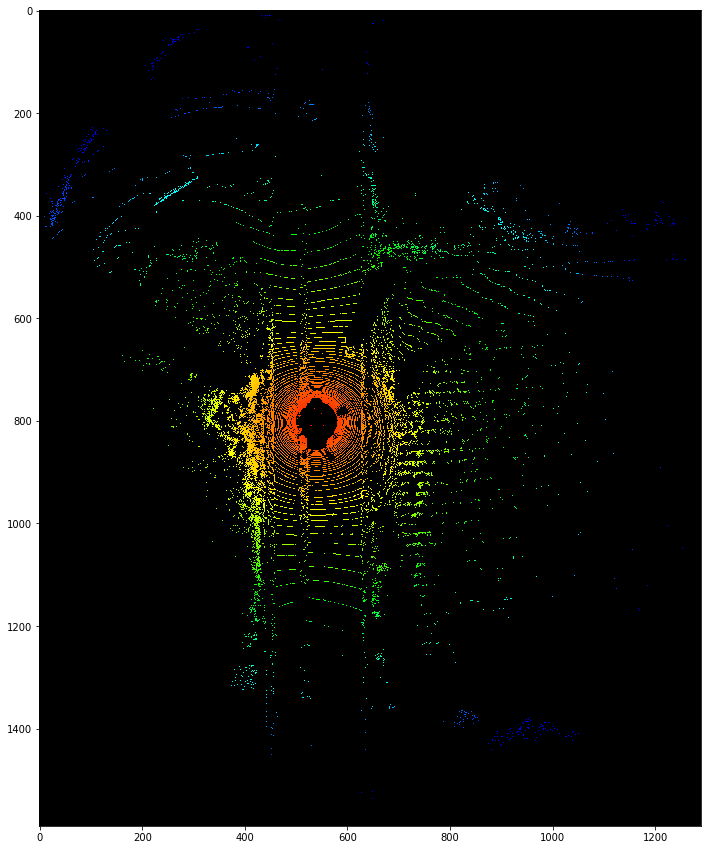

In [6]:
im = get_bev(points, pixel_values=get_distance_pixels(points), generate_img=get_heatmap)
f, axes = plt.subplots(1, 1, figsize=(15, 15))
axes.imshow(im)

## Filtering points from LiDAR point cloud

In [7]:
def filter_points(points, side_range=None, fwd_range=None, \
                  height_range=None, horizontal_fov=None, vertical_fov=None):
    '''
    Returns filtered points based on side, forward and height range, and, horizontal and vertical field of view.
    '''
    x = points[:, 0]
    y = points[:, 1]
    z = points[:, 2]
    r = points[:, 3]
    
    mask = np.full_like(x, True)
    
    if side_range is not None:
        side_mask = np.logical_and((y > -side_range[1]), (y < -side_range[0]))
        mask = np.logical_and(mask, side_mask)

    if fwd_range is not None:
        fwd_mask = np.logical_and((x > fwd_range[0]), (x < fwd_range[1]))
        mask = np.logical_and(mask, fwd_mask)

    if height_range is not None:
        height_mask = np.logical_and((z > height_range[0]), (z < height_range[1]))
        mask = np.logical_and(mask, height_mask)
        
    if horizontal_fov is not None:
        horizontal_fov_mask = np.logical_and(np.arctan2(y, x) > (-horizontal_fov[1] * np.pi / 180), \
                          np.arctan2(y, x) < (-horizontal_fov[0] * np.pi / 180))
        mask = np.logical_and(mask, horizontal_fov_mask)
    
    if vertical_fov is not None:
        distance = np.sqrt(x ** 2 + y ** 2 + z ** 2)
        vertical_fov_mask = np.logical_and(np.arctan2(z,distance) < (vertical_fov[1] * np.pi / 180), \
                          np.arctan2(z,distance) > (vertical_fov[0] * np.pi / 180))
        mask = np.logical_and(mask, vertical_fov_mask)

    indices = np.argwhere(mask).flatten()
    x_filtered = x[indices]
    y_filtered = y[indices]
    z_filtered = z[indices]
    r_filtered = r[indices]
    return np.vstack([x_filtered, y_filtered, z_filtered, r_filtered]).T

### Examples of `filter_points()`

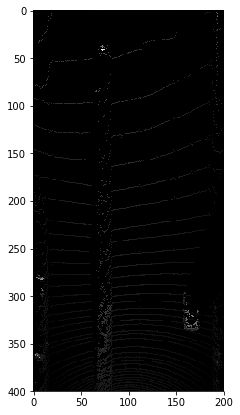

In [8]:
filtered = filter_points(points, side_range=(-10, 10), fwd_range=(6, 46))
im = get_bev(filtered)
f, axes = plt.subplots(1, 1, figsize=(7, 7))
plt.imshow(im, cmap='gray')

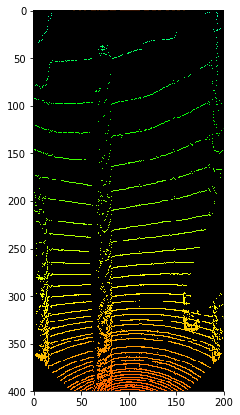

In [9]:
filtered = filter_points(points, side_range=(-10, 10), fwd_range=(6, 46), horizontal_fov=(-45, 45))
im = get_bev(filtered, pixel_values=get_distance_pixels(filtered), generate_img=get_heatmap)
f, axes = plt.subplots(1, 1, figsize=(7, 7))
plt.imshow(im, cmap='gray')